In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [2]:

# Chargement des fichiers CSV
benin_data = pd.read_csv("../../data/Bell_DNS Dataset/features_domain_benign_csv.csv")
malware_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Malware.csv")
phishing_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_phishing.csv")
spam_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Spam.csv")



In [4]:
benin_data['class']="benin"

print(benin_data['class'].value_counts())

class
benin    24249
Name: count, dtype: int64


In [36]:
##################################################################
#################################################################
################## Equilibrer #################################

# Prélèvement d'échantillons pour l'ensemble équilibré

# Échantillons bénins équilibrés : 20,000
benign_balanced_samples = benin_data.sample(20000, random_state=42)
benign_balanced_samples['class'] = 'bengnin'

balanced_spam = spam_data.sample(4337, random_state=42)
balanced_malware = malware_data.sample(4337, random_state=42)
balanced_phishing = phishing_data.sample(4337, random_state=42)

# Concaténation des échantillons équilibrés
malicioux_balanced_samples = pd.concat([balanced_spam, balanced_malware, balanced_phishing],axis=0, ignore_index=True)
malicioux_balanced_samples['class'] = 'malicioux'

balanced_all_data_resampled = pd.concat([malicioux_balanced_samples,benign_balanced_samples],axis=0, ignore_index=True)

print(" Size Malicioux data")
print(malicioux_balanced_samples['class'].value_counts())

print("\n")
print(" Size Bengnin data")
print(benign_balanced_samples['class'].value_counts())

print("\n")
print(" Size all data")
print(balanced_all_data_resampled['class'].value_counts())

print("\n")
print(" Size all data shape")
print(balanced_all_data_resampled.shape)




 Size Malicioux data
class
malicioux    13011
Name: count, dtype: int64


 Size Bengnin data
class
bengnin    20000
Name: count, dtype: int64


 Size all data
class
bengnin      20000
malicioux    13011
Name: count, dtype: int64


 Size all data shape
(33011, 36)


In [4]:
print(balanced_all_data_resampled.columns)

Index(['Domain_Age', 'sld', 'oc_8', 'Emails', 'hex_32', 'Domain_Name',
       'puny_coded', 'Page_Rank', 'Alexa_Rank', '3gram',
       'distance_from_bad_words', 'Country', 'hex_8', 'oc_32', 'len', 'typos',
       'Registrar', 'dec_8', '2gram', 'State', '1gram', 'obfuscate_at_sign',
       'entropy', 'numeric_percentage', 'Registrant_Name', 'subdomain',
       'char_distribution', 'shortened', 'longest_word', 'Name_Server_Count',
       'dec_32', 'Creation_Date_Time', 'Organization', 'tld', 'Unnamed: 34',
       'class'],
      dtype='object')


In [5]:
print(balanced_all_data_resampled.dtypes)


Domain_Age                  object
sld                         object
oc_8                         int64
Emails                      object
hex_32                       int64
Domain_Name                 object
puny_coded                   int64
Page_Rank                  float64
Alexa_Rank                 float64
3gram                       object
distance_from_bad_words     object
Country                     object
hex_8                        int64
oc_32                        int64
len                          int64
typos                       object
Registrar                   object
dec_8                        int64
2gram                       object
State                       object
1gram                       object
obfuscate_at_sign           object
entropy                    float64
numeric_percentage         float64
Registrant_Name             object
subdomain                  float64
char_distribution           object
shortened                   object
longest_word        

In [37]:
# Séparer les caractéristiques numériques et catégorielles (Balanced /Imbalanced)

X_numerical_balanced = balanced_all_data_resampled.select_dtypes(include=['int64', 'float64'])
X_categorical_balanced = balanced_all_data_resampled.select_dtypes(exclude='number').drop('class', axis=1)
y_balanced = balanced_all_data_resampled['class']

print(X_numerical_balanced.shape)
print(X_categorical_balanced.shape)
print(y_balanced.info())


(33011, 13)
(33011, 22)
<class 'pandas.core.series.Series'>
RangeIndex: 33011 entries, 0 to 33010
Series name: class
Non-Null Count  Dtype 
--------------  ----- 
33011 non-null  object
dtypes: object(1)
memory usage: 258.0+ KB
None


In [7]:
print(X_numerical_balanced.dtypes)



oc_8                    int64
hex_32                  int64
puny_coded              int64
Page_Rank             float64
Alexa_Rank            float64
hex_8                   int64
oc_32                   int64
len                     int64
dec_8                   int64
entropy               float64
numeric_percentage    float64
subdomain             float64
dec_32                  int64
dtype: object


In [8]:
print(X_categorical_balanced.dtypes)


Domain_Age                 object
sld                        object
Emails                     object
Domain_Name                object
3gram                      object
distance_from_bad_words    object
Country                    object
typos                      object
Registrar                  object
2gram                      object
State                      object
1gram                      object
obfuscate_at_sign          object
Registrant_Name            object
char_distribution          object
shortened                  object
longest_word               object
Name_Server_Count          object
Creation_Date_Time         object
Organization               object
tld                        object
Unnamed: 34                object
dtype: object


In [38]:
############## Finalement les features selectionness avec le gain d'information et ratio et gini index et coeff correlaation #####



X_numerical_balanced = balanced_all_data_resampled[['Page_Rank','puny_coded','entropy','len','numeric_percentage','dec_32','oc_8','oc_32']]
X_categorical_balanced = balanced_all_data_resampled[['Unnamed: 34','char_distribution','Registrant_Name','Domain_Name',
                        'distance_from_bad_words','Creation_Date_Time','sld','1gram','2gram','3gram',
                        'shortened','obfuscate_at_sign','Country','Organization','State','Emails','Domain_Age']]
y_balanced = balanced_all_data_resampled['class']

In [10]:
print(X_numerical_balanced.shape)
print(X_categorical_balanced.shape)
print(y_balanced.shape)


(33011, 8)
(33011, 17)
(33011,)


In [39]:
from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques numériques

# Imputer les valeurs manquantes pour les caractéristiques numériques
numerical_imputer = SimpleImputer(strategy='mean')
X_numerical_balanced_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical_balanced), columns=X_numerical_balanced.columns)


In [40]:
from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques catégorielles

categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_balanced_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical_balanced),columns=X_categorical_balanced.columns)


In [41]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# Sélection des fonctionnalités numériques

# numeric_features = X_numerical_imputed[numeric_imputed_list] ## cas ou je veux selectionné certains features

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(X_numerical_balanced_imputed)

# Transformation des fonctionnalités numériques
scaled_numeric_balanced = scaler.transform(X_numerical_balanced_imputed)

# Apres transformation Création d' un DataFrame à partir des valeurs transformées

scaled_df_balanced = pd.DataFrame(scaled_numeric_balanced, columns=X_numerical_balanced_imputed.columns)


total_size_balanced = scaled_df_balanced.shape

print("Taille totale des caracteristiques numeriques apres preprocessing :", total_size_balanced)


Taille totale des caracteristiques numeriques apres preprocessing : (33011, 8)


In [42]:
#############  executer #################################


categorical_balanced_imputed_list = categorical_balanced_imputed.columns.tolist()

print(categorical_balanced_imputed_list)
print("\n")

print(categorical_balanced_imputed.shape)

['Unnamed: 34', 'char_distribution', 'Registrant_Name', 'Domain_Name', 'distance_from_bad_words', 'Creation_Date_Time', 'sld', '1gram', '2gram', '3gram', 'shortened', 'obfuscate_at_sign', 'Country', 'Organization', 'State', 'Emails', 'Domain_Age']


(33011, 17)


In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd


#Créer une copie du DataFrame pour éviter SettingWithCopyWarning

X_copy_balanced = categorical_balanced_imputed.copy()  

# Appliquer une tokenisation à chaque colonne catégorielle
for feature in categorical_balanced_imputed_list:
    X_copy_balanced[feature] = X_copy_balanced[feature].astype(str)

X_copy_balanced['combined_text'] = X_copy_balanced[categorical_balanced_imputed_list].apply(lambda row: ' '.join(row), axis=1)

tokenizer = Tokenizer(num_words=100, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy_balanced['combined_text'])
tokens_balanced = tokenizer.texts_to_sequences(X_copy_balanced['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length_balanced = max(len(seq) for seq in tokens_balanced)


#### Pas necessaire cas gourmanad en memoire pour mon pc ############
####################################################################


# Ajout des colonnes tokenisées au DataFrame
# for i in range(1, max_sequence_length_balanced + 1):
    # X_copy_balanced[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens_balanced]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
# X_copy_balanced.drop(columns=categorical_balanced_imputed_list + ['combined_text'], inplace=True)

###################################### Fin ####################################


# Afficher les tokens_balanced et les longueurs de séquence
print("tokens_balanced:")
print(tokens_balanced)

seq_l = [len(seq) for seq in tokens_balanced]




# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur balanced : {max_sequence_length_balanced}")

tokens_balanced:
[[4, 5, 6, 70, 2, 45, 2, 33, 19, 22, 19, 43, 1, 35, 1, 20, 67, 40, 1, 31, 19, 59, 1, 38, 1, 58, 1, 24, 11, 7, 9, 8, 22, 36, 32, 55, 15, 28, 18, 41, 55, 15, 26, 18, 32, 76, 73, 17, 47, 28, 51, 15, 32, 18, 17, 83, 93, 65, 3, 23, 25, 21, 12], [4, 5, 6, 75, 2, 46, 1, 54, 19, 16, 1, 29, 2, 42, 1, 40, 1, 52, 1, 22, 1, 38, 1, 30, 11, 7, 9, 8, 17, 53, 15, 18, 34, 48, 15, 41, 13, 56, 65, 3, 14, 12], [4, 5, 6, 75, 2, 46, 1, 30, 1, 29, 1, 42, 1, 33, 1, 52, 1, 24, 1, 11, 7, 9, 8, 53, 15, 17, 28, 56, 26, 48, 66, 65, 3, 14, 21, 12], [4, 5, 6, 1, 20, 1, 29, 1, 16, 1, 31, 1, 22, 1, 24, 11, 7, 9, 8, 17, 18, 32, 13, 26, 89, 97, 71, 65, 3, 21, 12], [4, 5, 6, 1, 31, 1, 22, 1, 30, 19, 35, 1, 20, 1, 46, 1, 54, 19, 16, 2, 38, 1, 24, 2, 29, 11, 7, 9, 8, 87, 13, 26, 74, 18, 41, 13, 34, 48, 17, 26, 32, 15, 36, 66, 71, 90, 65, 3, 14, 12], [4, 5, 6, 1, 20, 1, 29, 1, 16, 1, 31, 1, 22, 1, 24, 11, 7, 9, 8, 17, 18, 32, 13, 26, 89, 97, 71, 65, 3, 21, 12], [4, 5, 6, 75, 2, 46, 1, 61, 1, 29, 2, 16, 1, 3

In [28]:
print(max_sequence_length_balanced)

116


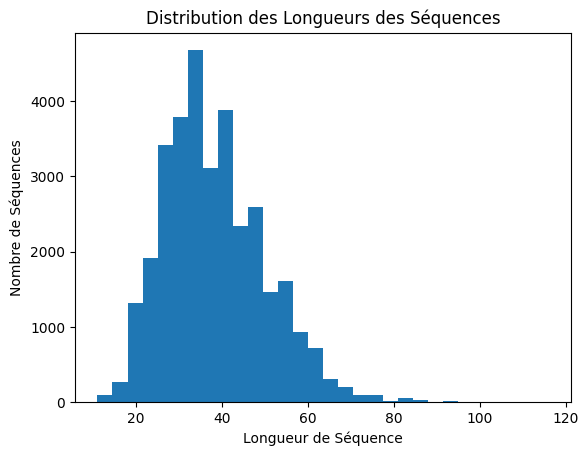

In [44]:
############ affichage longueur  max "balanced categorical feature"
seq_lenght = seq_l


mean_length = np.mean(seq_lenght)
max_length = np.max(seq_lenght)
min_length = np.min(seq_lenght)
std_dev = np.std(seq_lenght)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(seq_lenght, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()

In [45]:
# Calculer la taille du vocabulaire réel
vocab_size = len(tokenizer.word_index) + 1  # Ajoutez 1 pour tenir compte du padding

# Afficher la taille du vocabulaire
print("Taille réelle du vocabulaire:", vocab_size)

Taille réelle du vocabulaire: 121813


In [46]:
# Hyperparamètres et dimensions des données*
taille_num_features_balanced = scaled_df_balanced.shape[1]
taille_text_features_balanced = max_sequence_length_balanced   # je donne la taille max parmi les longueur des sequences 
embedding_dim = 128  ## sa dimension ne doit pas depasser la valeur du [d_model dans l'encodeur] 

vocab_size = 121813

In [19]:

from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Dropout
from tensorflow.keras.optimizers.legacy import Adam

# tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)



# Entrées

############## Balanced Model ####################

input_num = tf.keras.layers.Input(shape=(taille_num_features_balanced,))
input_text = tf.keras.layers.Input(shape=(taille_text_features_balanced,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)


# Branche textuelle - Embedding + LSTM
# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features_balanced)(input_text)

mask_inputs = masque_remplissage(input_text) 

out_seq = Encodeur(
            n_layers=4,
            d_model=128,
            num_heads=2,
            middle_units=256,
            max_seq_len=taille_text_features_balanced)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches 

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

# Couches supplémentaires après la fusion
merged = Dropout(0.4)(merged)
merged = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged) 

# Création et compilation du modèle

model_balanced = Model(inputs=[input_num, input_text], outputs=output)
opt = Adam(learning_rate=0.0001)

model_balanced.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


print(model_balanced.summary())


In [47]:
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Dropout
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras.models import Model

# Entrées
input_num = Input(shape=(taille_num_features_balanced,))
input_text = Input(shape=(taille_text_features_balanced,))

# Caractéristiques numériques - Réseau dense
num_branch = Dense(128, activation='relu')(input_num)
num_branch = Dense(64, activation='relu')(num_branch)

# Caractéristiques textuelles - Réseau CNN
embedding_dim = 128
vocab_size = 121813
max_sequence_length = taille_text_features_balanced

text_branch = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_text)
conv_filters = [128, 128, 128]
filter_sizes = [3, 4, 5]

conv_blocks = []
for filter_size, num_filters in zip(filter_sizes, conv_filters):
    conv = Conv1D(filters=num_filters,
                  kernel_size=filter_size,
                  padding='valid',
                  activation='relu')(text_branch)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

text_representation = concatenate(conv_blocks)

# Fusion des branches
merged = concatenate([num_branch, text_representation])

# Couches supplémentaires après la fusion
merged = Dropout(0.5)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dense(128, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged)

# Création et compilation du modèle
model = Model(inputs=[input_num, input_text], outputs=output)
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 116)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 116, 128)     15592064    ['input_4[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 114, 128)     49280       ['embedding_1[0][0]']            
                                                                                            

In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Entrées pour l'entraînement
data_num_balanced = scaled_df_balanced   
data_text_balanced = pad_sequences(tokens_balanced, maxlen=max_sequence_length_balanced,padding='post')


In [49]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Encodage de la cible en labels numériques
label_encoder = LabelEncoder()
# print(y_balanced) [o=bengnin ,1=malicioux]
y_balanced_encoded = label_encoder.fit_transform(y_balanced)
print(y_balanced_encoded)
print(y_balanced_encoded.shape)


[1 1 1 ... 0 0 0]
(33011,)


In [50]:
################# Balanced and Imbalanced #########################

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
balanced_text_train, balanced_text_test, balanced_num_train, balanced_num_test, balanced_labels_train, balanced_labels_test = train_test_split(
    data_text_balanced, data_num_balanced, y_balanced_encoded, test_size=0.2, random_state=42
)


In [33]:
print("Shape of text_train:", balanced_text_train.shape)
print("Shape of labels_train:", balanced_labels_train.shape)
print("Shape of text_test:", balanced_text_test.shape)
print("Shape of labels_test:", balanced_labels_test.shape)
print("Shape of num_train:", balanced_num_train.shape)
print("Shape of num_test:", balanced_num_test.shape)

print("Visualisation des dimension et du batch_size\n")

batch_size, dimension = balanced_text_train.shape[0], balanced_text_train.shape[1]
print("Batch size text train:", batch_size)
print("Dimension text train:", dimension)

batch_size, dimension = balanced_num_train.shape[0], balanced_num_train.shape[1]
print("Batch size num train:", batch_size)
print("Dimension num train:", dimension)



Shape of text_train: (26408, 116)
Shape of labels_train: (26408,)
Shape of text_test: (6603, 116)
Shape of labels_test: (6603,)
Shape of num_train: (26408, 8)
Shape of num_test: (6603, 8)
Visualisation des dimension et du batch_size

Batch size text train: 26408
Dimension text train: 116
Batch size num train: 26408
Dimension num train: 8


In [25]:
# Afficher quelques exemples des données d'entraînement
print("Exemples des données d'entraînement:")
print("Text_train:")
print(balanced_text_train[:5])
print("\nNum_train:")
print(balanced_num_train[:5])
print("\nLabels_train:")
print(balanced_labels_train[:5])

# Faire de même pour les données de test


# Vérifier si des valeurs nan sont présentes
print("\nVérification des valeurs nan:")
print("Text_train contains nan:", np.isnan(balanced_text_train).any())
print("Num_train contains nan:", np.isnan(balanced_num_train).any())
print("Labels_train contains nan:", np.isnan(balanced_labels_train).any())

# Faire de même pour les données de test



Exemples des données d'entraînement:
Text_train:
[[ 4  5  6 81  1 38  1 20  2 52  1 22  1 45  1 35 19 24  1 16 72 50 39 13
  41 15 36 36 55 13 15 36 18 28 68 10  3 14 23 25 21 27  3  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  5  6  2 22  1 29  1 33  1 30  2 38  1 43  1 49 11  7  9  8 39 18 17
  28 34 41 36 47 57 66 10  3 14 37 12  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  5  6 81  1 38  2 24  1 20  7  9  8 63 64 20 50 39 91 15 28 15 41 15
  83 10  3 14 23 25 21 27 37  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 

In [51]:
### Balanced 

history_balanced= model.fit([balanced_num_train,balanced_text_train], balanced_labels_train , epochs=30, batch_size=128, validation_data=([balanced_num_test,balanced_text_test],balanced_labels_test))


Train on 26408 samples, validate on 6603 samples
Epoch 1/30
26408/26408 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9020

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


26408/26408 [==============================] - 278s 11ms/sample - loss: 0.2160 - accuracy: 0.9020 - val_loss: 0.0868 - val_accuracy: 0.9674
Epoch 2/30
26408/26408 [==============================] - 268s 10ms/sample - loss: 0.0826 - accuracy: 0.9685 - val_loss: 0.0679 - val_accuracy: 0.9729
Epoch 3/30
26408/26408 [==============================] - 259s 10ms/sample - loss: 0.0667 - accuracy: 0.9745 - val_loss: 0.0593 - val_accuracy: 0.9779
Epoch 4/30
26408/26408 [==============================] - 256s 10ms/sample - loss: 0.0569 - accuracy: 0.9781 - val_loss: 0.0572 - val_accuracy: 0.9800
Epoch 5/30
26408/26408 [==============================] - 273s 10ms/sample - loss: 0.0541 - accuracy: 0.9791 - val_loss: 0.0522 - val_accuracy: 0.9811
Epoch 6/30
26408/26408 [==============================] - 293s 11ms/sample - loss: 0.0474 - accuracy: 0.9814 - val_loss: 0.0545 - val_accuracy: 0.9797
Epoch 7/30
26408/26408 [==============================] - 295s 11ms/sample - loss: 0.0419 - accuracy: 0.9

In [53]:
#on effectue les prediction sur les donnees de test

y_pred_balanced = model.predict([balanced_num_test,balanced_text_test])

y_pred_balanced = np.round(y_pred_balanced)
                
### Evaluation
                             
evaluation_results_balanced = model.evaluate([balanced_num_test,balanced_text_test], balanced_labels_test)


# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Balanced Perte sur les données de test:", evaluation_results_balanced[0])
print("Balanced Précision sur les données de test:", evaluation_results_balanced[1])


c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Balanced Perte sur les données de test: 0.0534769821809951
Balanced Précision sur les données de test: 0.98409814


In [54]:
from sklearn.metrics import classification_report,accuracy_score


# Afficher le rapport de classification
class_report_balanced = classification_report(balanced_labels_test, y_pred_balanced)
print("Balanced Rapport de classification :\n", class_report_balanced)


Balanced Rapport de classification :
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4015
           1       0.98      0.98      0.98      2588

    accuracy                           0.98      6603
   macro avg       0.98      0.98      0.98      6603
weighted avg       0.98      0.98      0.98      6603



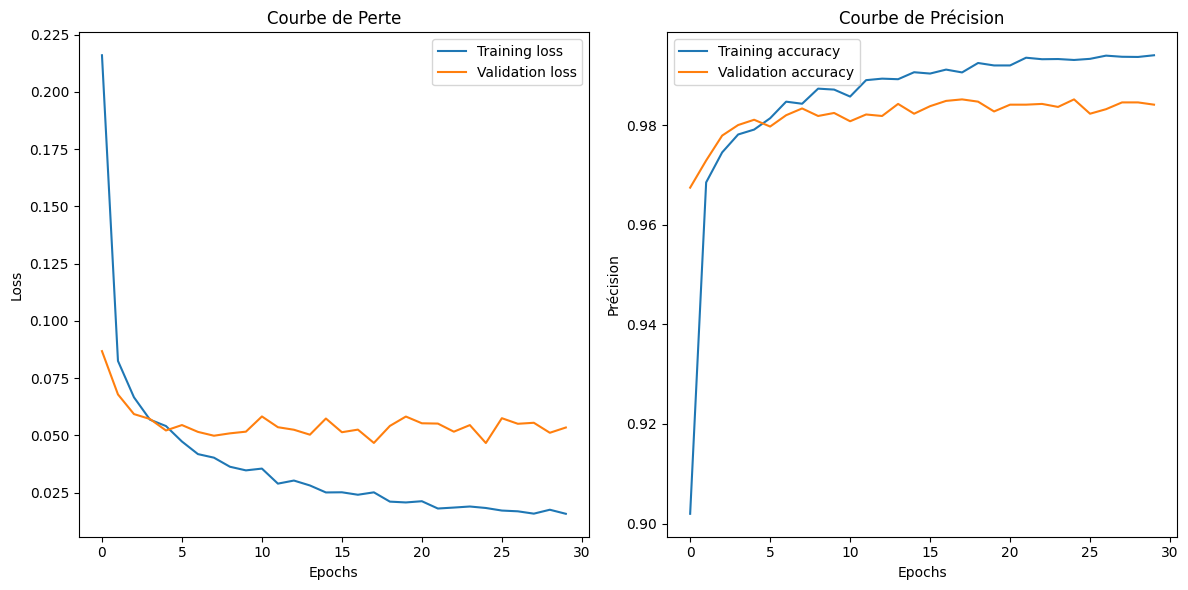

In [55]:
########## Balanced ########

# Extraction des métriques d'entraînement
loss = history_balanced.history['loss']
accuracy = history_balanced.history['accuracy']
val_loss = history_balanced.history['val_loss']
val_accuracy = history_balanced.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history_balanced.history['loss'], label='Training loss')
plt.plot(history_balanced.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history_balanced.history['accuracy'], label='Training accuracy')
plt.plot(history_balanced.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

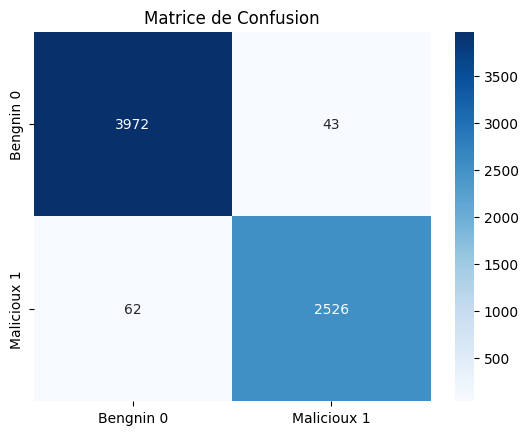

In [56]:
#### Balanced #######


#affichage de la matrixe de confusion

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix


#calul preliminaire pour obtenir la matrice de confusion

conf_matrix = confusion_matrix(balanced_labels_test,y_pred_balanced)
true_negatives, false_positives,false_negatives, true_positives = conf_matrix.ravel()

# Créer la matrice de confusion
conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# Afficher la matrice de confusion avec seaborn
df_cm = pd.DataFrame(conf_matrix, index=['Bengnin 0', 'Malicioux 1'], columns=['Bengnin 0', 'Malicioux 1'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de Confusion')
plt.show()


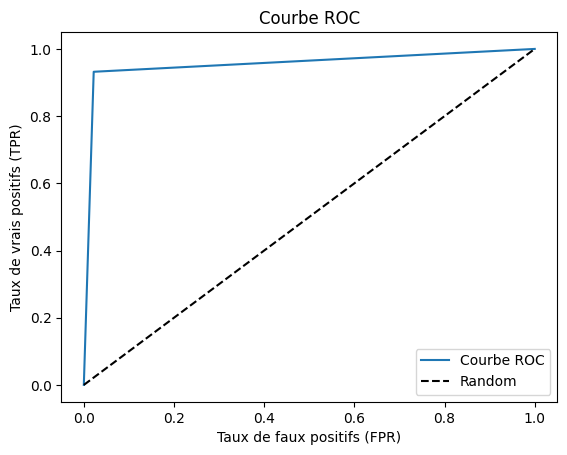

Aire sous la courbe (AUC) : 0.9550380047003029


In [31]:
############## Imbalanced ##################

############## courbe de roc ########

#Courbe de ROC

from sklearn.metrics import roc_curve, roc_auc_score

# Calcul des taux FPR et TPR
fpr, tpr, thresholds = roc_curve(balanced_labels_test, y_pred_balanced)

# Plotter la courbe ROC
plt.plot(fpr, tpr, label='Courbe ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

# Calcul de l'AUC
auc = roc_auc_score(balanced_labels_test, y_pred_balanced)
print('Aire sous la courbe (AUC) :', auc)
